In [257]:
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("seaborn-v0_8")
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

rs = 42 # random state
torch.manual_seed(rs)  # torch random state

# Dataset overview

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Dataset statistics:


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


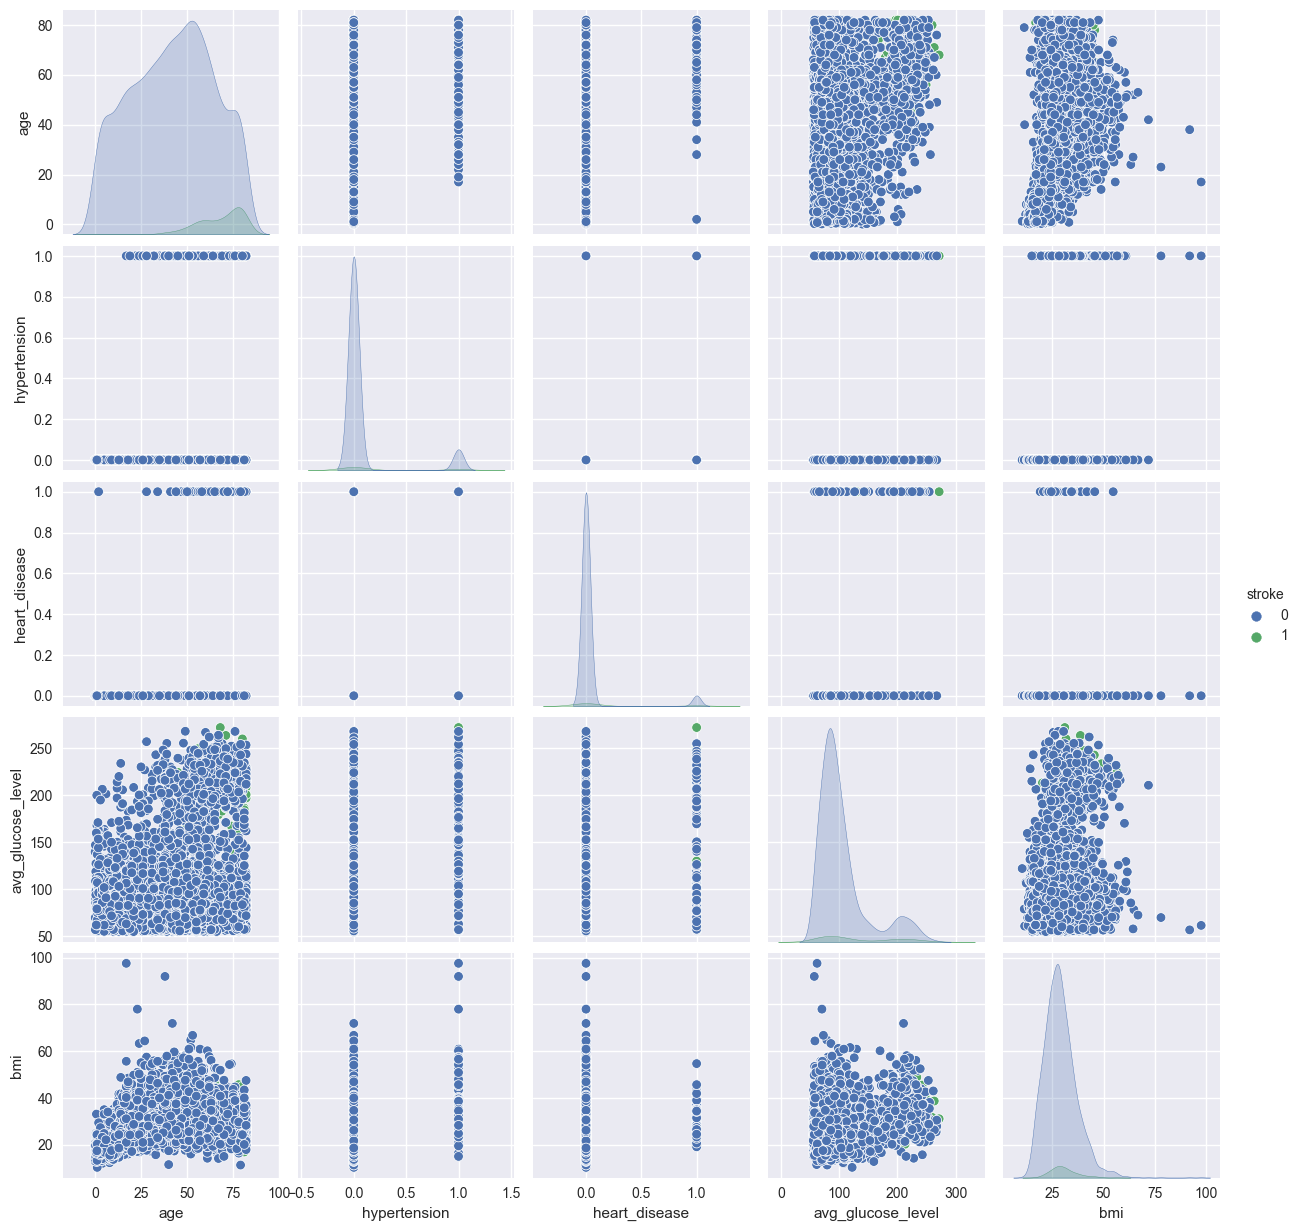

In [259]:
df_raw = pd.read_csv("healthcare-dataset-stroke-data.csv")
df_raw = df_raw.drop(columns=['id'])
display(df_raw.head())
print("Dataset statistics:")
display(df_raw.describe())

sns.pairplot(df_raw, hue='stroke')
plt.show()

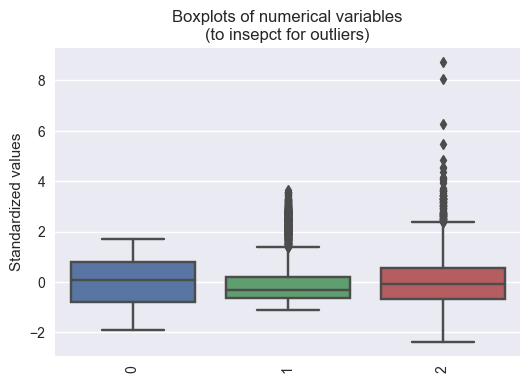

In [280]:
# Outliers inspection for numerical variables
plt.figure(figsize=(6, 4))
scaler = StandardScaler() # first standardize the data to make the boxplots comparable
sns.boxplot(data=scaler.fit_transform(df_raw[['age', 'avg_glucose_level', 'bmi']]))
plt.title("Boxplots of numerical variables\n(to insepct for outliers)")
plt.xticks(rotation=90)
plt.ylabel("Standardized values")
plt.show()

/var/folders/r8/9_x5mqbs79gbpktlgmt3lyb40000gn/T/ipykernel_51835/1394802410.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_raw.corr("pearson").round(3)


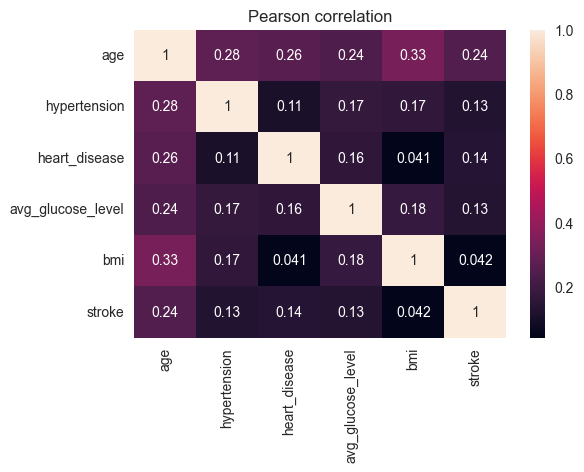

In [281]:
# Initial correlation plot (this excludes categorical variables since they are not encoded yet)
plt.figure(figsize=(6, 4))
corr = df_raw.corr("pearson").round(3)
sns.heatmap(corr, annot=True)
plt.title("Pearson correlation")
plt.show()

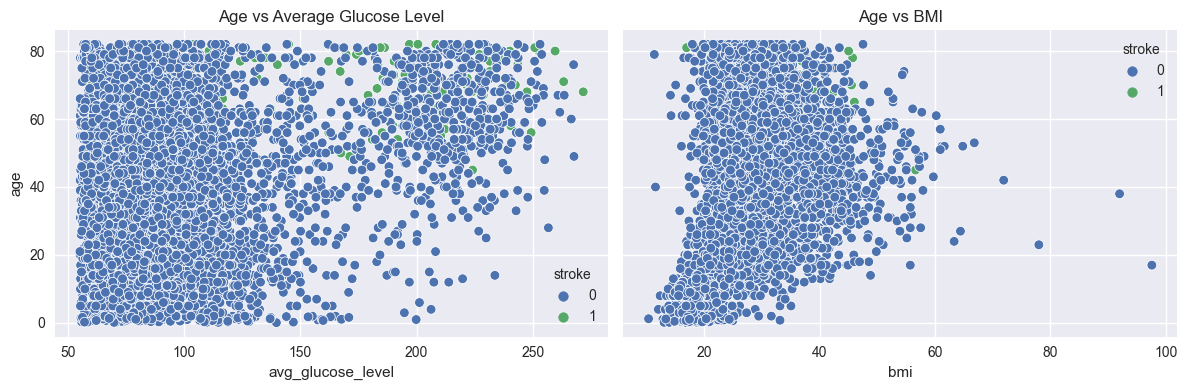

In [277]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.scatterplot(data=df_raw, y="age", x="avg_glucose_level", hue="stroke", ax=axes[0])
axes[0].set_title("Age vs Average Glucose Level")

sns.scatterplot(data=df_raw, y="age", x="bmi", hue="stroke", ax=axes[1])
axes[1].set_title("Age vs BMI")

plt.tight_layout()
plt.show()

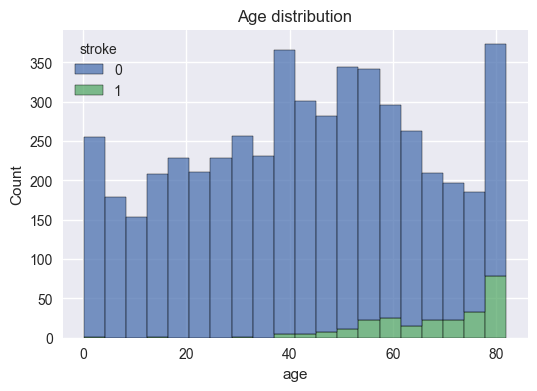

In [265]:
plt.figure(figsize=(6, 4))
sns.histplot(df_raw, x="age", hue="stroke", multiple="stack")
plt.title("Age distribution")
plt.show()

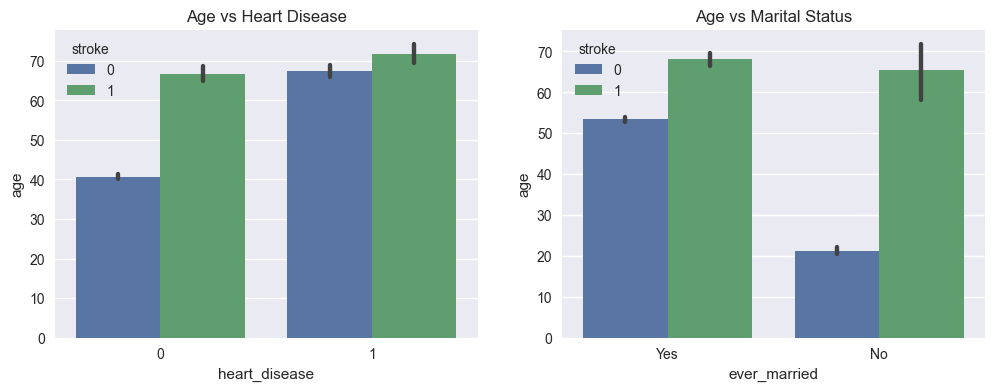

In [273]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(data=df_raw, x="heart_disease", y="age", hue="stroke", ax=axes[0])
axes[0].set_title("Age vs Heart Disease")

sns.barplot(data=df_raw, x="ever_married", y="age", hue="stroke", ax=axes[1])
axes[1].set_title("Age vs Marital Status")

plt.show()

# Preprocessing

In [ ]:
# Under sampling: Remove instance  from the overrepresented class (randomly)
# Over sampling: SMOTE (Synthetic Minority Over-sampling Technique)
# Ensemble methods (Random Forest, XGBoost, etc.) are naturally robust to imbalanced data

# create more features to help the model better predict stroke ??

In [245]:
df_raw = pd.read_csv("healthcare-dataset-stroke-data.csv")

# remove ID column
df_processed = df_raw.drop(columns=['id'])

# Change only record with gender "other" to majority
df_processed.iloc[3116, 0] = "Female"

# remove records with too low age
# the data contained a lot of records with age close to 0 ??
df_processed = df_processed[df_processed.age >= 10]

# Perform Undersampling to account for data imbalance
# randomly remove 80% of the non-stroke instances
df_processed = df_processed.drop(df_processed.query("stroke == 0").sample(frac=.8).index)

# Remove singe BMI outlier with BMI of 97,5
df_processed = df_processed[df_processed.bmi < 60]

# imputing missing values for BMI using KNN technique
imputer = KNNImputer(n_neighbors=5)
df_processed['bmi'] = imputer.fit_transform(df_processed[['bmi']])

# Encode categorical variables as numbers
def encode_numericals(df: pd.DataFrame) -> pd.DataFrame:
    df_return = df.copy()
    df_return['ever_married'] = df_return['ever_married'].replace({'Yes': 1, 'No': 0})
    df_return['work_type'] = df_return['work_type'].replace({'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4})
    df_return['Residence_type'] = df_return['Residence_type'].replace({'Urban': 1, 'Rural': 0})
    df_return['smoking_status'] = df_return['smoking_status'].replace({'formerly smoked': 0, 'never smoked': 1, 'smokes': 2, 'Unknown': 3})
    df_return['gender'] = df_return['gender'].replace({"Female": 0, "Male": 1, "Other": 2})
    return df_return
df_processed = encode_numericals(df_processed)

Distribution of classes with synthetic data:
{'not stroke': 848, 'stroke': 593}


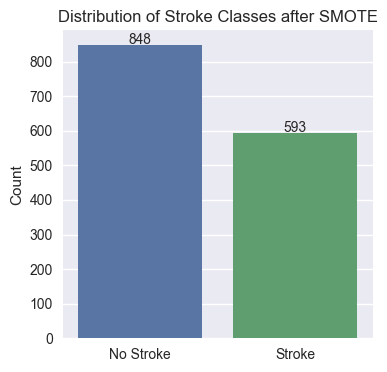

In [246]:
# SMOTE: oversampling using k-nearest neighbors to create synthetic data
oversampling_ratio = 0.7 # can only be used for binary classification
smote = SMOTE(sampling_strategy=oversampling_ratio, k_neighbors=5, random_state=rs)
X = df_processed.drop(columns=['stroke'])
y = df_processed['stroke']
X_resampled, y_resampled = smote.fit_resample(X, y)
df_processed = pd.concat([X_resampled, y_resampled], axis=1)

unique, counts = np.unique(df_processed.stroke, return_counts=True)
print("Distribution of classes with synthetic data:")
print(dict(zip(("not stroke", "stroke"), counts)))

# Stroke distribution after SMOTE
plt.figure(figsize=(4, 4))
sns.countplot(data=df_processed, x='stroke')
plt.xticks([0, 1], ['No Stroke', 'Stroke'])  # Change x labels
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height():.0f}", (p.get_x() + p.get_width() / 2, p.get_height() + 15), ha='center', va='center')
plt.xlabel('')
plt.ylabel('Count')
plt.title('Distribution of Stroke Classes after SMOTE')
plt.show()

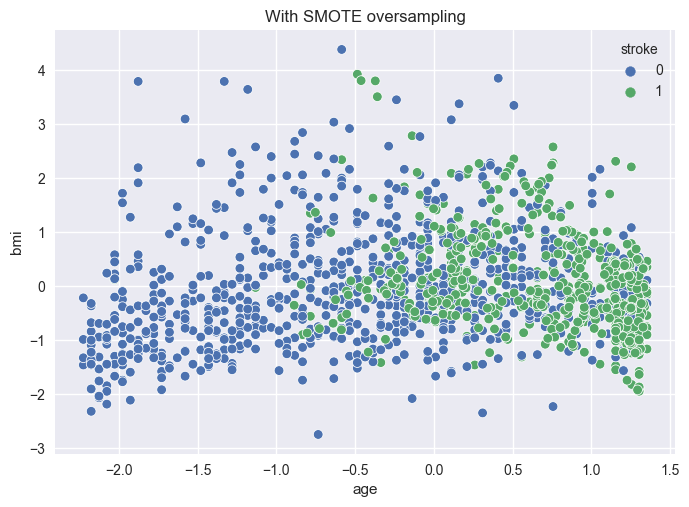

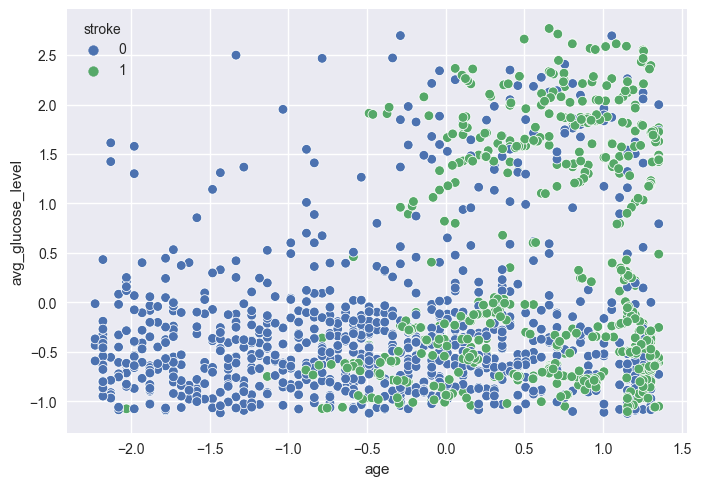

In [269]:
sns.scatterplot(data=df_processed, x="age", y="bmi", hue="stroke")
plt.title("With SMOTE oversampling")
plt.show()

sns.scatterplot(data=df_processed, x="age", y="avg_glucose_level", hue="stroke")
plt.show()

Text(0.5, 1.0, 'Pearson correlation')

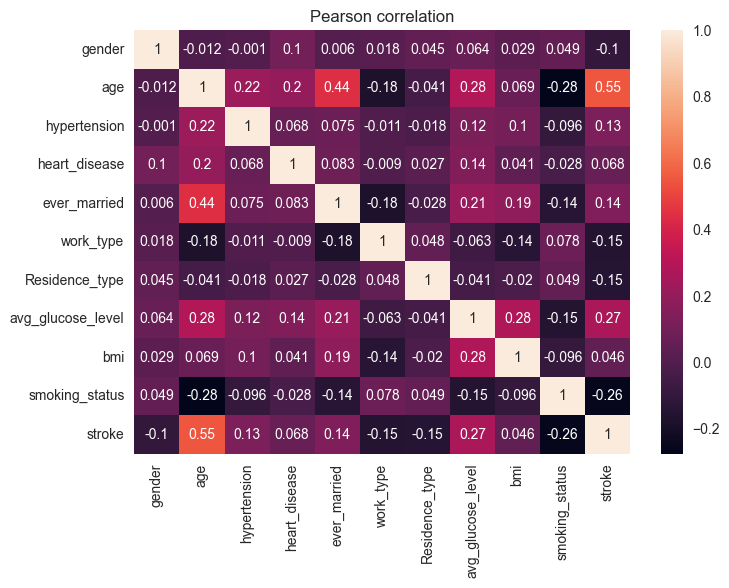

In [106]:
# make correlation plot
corr = df_processed.corr("pearson").round(3)
sns.heatmap(corr, annot=True)
plt.title("Pearson correlation")

# Model Training

In [249]:
# feature stanardisation for numerical features
df_processed[['age','avg_glucose_level', 'bmi']] = scaler.fit_transform(df_processed[['age', 'avg_glucose_level', 'bmi']])

# one hot encoding
categorical_variables = ['work_type', 'smoking_status']
df_processed = pd.get_dummies(df_processed, columns=categorical_variables, drop_first=True) # drop_first to avoid dummy variable trap.
df_processed.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_1,work_type_2,work_type_3,work_type_4,smoking_status_1,smoking_status_2,smoking_status_3
0,1,0.608216,0,1,1,1,1.994879,0.964449,1,0,0,0,0,0,0,0
1,1,1.254862,0,1,1,0,-0.213522,0.357993,1,0,0,0,0,1,0,0
2,0,-0.287141,0,0,1,1,0.961282,0.639034,1,0,0,0,0,0,1,0
3,0,1.205120,1,0,1,0,1.013267,-0.899296,1,1,0,0,0,1,0,0
4,1,1.304604,0,0,1,1,1.230744,-0.159714,1,0,0,0,0,0,0,0


Accuracy:  0.8581314878892734


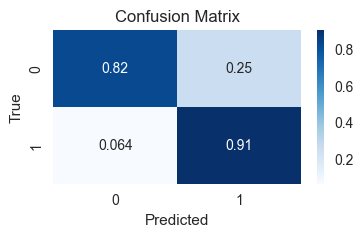

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       171
           1       0.78      0.91      0.84       118

    accuracy                           0.86       289
   macro avg       0.85      0.87      0.86       289
weighted avg       0.87      0.86      0.86       289



In [284]:

def train_rf_model(dataset, split_ratio: float = 0.2):
    X = dataset.drop(columns=['stroke'])
    y = dataset['stroke']
    # split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio)

    # fit a random forest classifier
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    # make predictions
    y_pred = clf.predict(X_test)

    # evaluate the model

    print("Accuracy: ", accuracy_score(y_test, y_pred))

    # confusion matrix
    plt.figure(figsize=(4, 2))
    cf_matrix = confusion_matrix(y_test, y_pred)
    cf_matrix = cf_matrix / cf_matrix.astype(float).sum(axis=1)
    sns.heatmap(cf_matrix, annot=True, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    print(classification_report(y_test, y_pred))

train_rf_model(df_processed)

# Train Simple Neural Network

In [179]:
# split data into train and test sets
X = df_processed.drop(columns=['stroke'])
y = df_processed['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)

# convert data to tensors for training
X_train = torch.tensor(X_train.values, dtype=torch.float)
y_train = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float)
X_test = torch.tensor(X_test.values, dtype=torch.float)
y_test = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float)

In [202]:
# simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# hyperparameters
n_features = X_train.shape[1]
input_size = n_features
hidden_size = n_features * 2
output_size = 1

# instantiate model
model = SimpleNN(input_size, hidden_size, output_size)

# loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=lr)

# Training loop
num_epochs = 5000
for epoch in range(num_epochs):
    # Forward pass:
    outputs = model(X_train)
    # Compute the loss:
    loss = criterion(outputs, y_train)
    # Backward pass and optimization:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print loss every 500 epochs
    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        # calculate evaluation metrics:
        outputs = outputs.detach().numpy()
        outputs = np.where(outputs >= 0.5, 1, 0)
        print(f"Accuracy: {accuracy_score(y_train, outputs):.4f}")
        print(f"F1-score: {f1_score(y_train, outputs)}:.4f")
        print(f"Precision: {precision_score(y_train , outputs)}:.4f")
        print(f"Recall: {recall_score(y_train, outputs)}:.4f")
        print("")

Epoch [100/5000], Loss: 0.6424
Accuracy: 0.6928
F1-score: 0.5179407176287051:.4f
Precision: 0.7579908675799086:.4f
Recall: 0.3933649289099526:.4f

Epoch [200/5000], Loss: 0.6127
Accuracy: 0.6899
F1-score: 0.5031847133757963:.4f
Precision: 0.7669902912621359:.4f
Recall: 0.3744075829383886:.4f

Epoch [300/5000], Loss: 0.5856
Accuracy: 0.7207
F1-score: 0.5812220566318926:.4f
Precision: 0.7831325301204819:.4f
Recall: 0.46208530805687204:.4f

Epoch [400/5000], Loss: 0.5611
Accuracy: 0.7515
F1-score: 0.6527777777777778:.4f
Precision: 0.7885906040268457:.4f
Recall: 0.556872037914692:.4f

Epoch [500/5000], Loss: 0.5400
Accuracy: 0.7644
F1-score: 0.689384010484928:.4f
Precision: 0.7712609970674487:.4f
Recall: 0.6232227488151659:.4f

Epoch [600/5000], Loss: 0.5226
Accuracy: 0.7694
F1-score: 0.7085427135678393:.4f
Precision: 0.7540106951871658:.4f
Recall: 0.6682464454976303:.4f

Epoch [700/5000], Loss: 0.5090
Accuracy: 0.7714
F1-score: 0.7174447174447175:.4f
Precision: 0.7448979591836735:.4f
Reca

Accuracy:  0.8009259259259259
F1-score:  0.7528735632183908
Precision:  0.7359550561797753
Recall:  0.7705882352941177


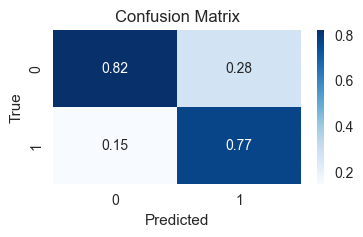

In [285]:
# Evaluate the model on the test set:
predicted_probs = model(X_test)
predicted_labels = (predicted_probs > 0.5).float()
predicted_labels = predicted_labels.detach().numpy()
print("Accuracy: ", accuracy_score(y_test, predicted_labels))
print("F1-score: ", f1_score(y_test, predicted_labels))
print("Precision: ", precision_score(y_test , predicted_labels))
print("Recall: ", recall_score(y_test, predicted_labels))

# confusion matrix
plt.figure(figsize=(4, 2))
cf_matrix = confusion_matrix(y_test, predicted_labels)
cf_matrix = cf_matrix / cf_matrix.astype(float).sum(axis=1)
sns.heatmap(cf_matrix, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()